In [2]:
import numpy as np
import pandas as pd

In [3]:
# 导入数据集
train_data = pd.read_csv('./input/train.csv', index_col=0)
test_data = pd.read_csv('./input/test.csv', index_col=0)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.style as psl
psl.use('seaborn-colorblind')    # 设置图表风格
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

## 数据预处理
### 提取 y_train 并做相应处理

先将销售的价格取出来，查看以下它的分布情况。

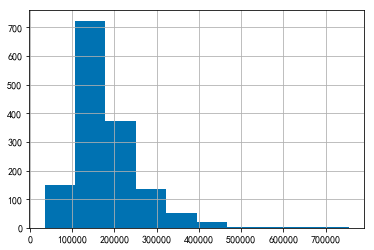

In [5]:
y_train = train_data.pop('SalePrice')
y_train.hist()

由此可见数据并不平滑，因此我们将其正态化，正态化之前，先看一下如果正态化之后的价格分布

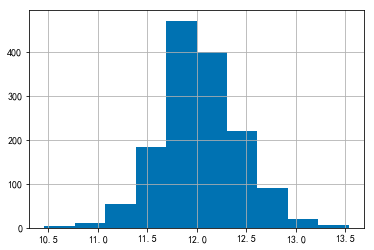

In [6]:
np.log1p(y_train).hist()

这样的分布就很好了，因此我们通过 numpy 的 log1p() 将 y_train 正态化。

In [7]:
y_train = np.log1p(y_train)

### 将去掉 SalePrice 的训练集合测试集合并

将两个数据集合并的目的是为了将两个数据集一起处理，减少重复的步骤

In [8]:
data = pd.concat((train_data, test_data), axis=0)
data.shape

(2919, 79)

### 特征处理
数据集中有几个跟年份有关的属性，分别是：
- YrSold: 售出房子的年份；
- YearBuilt：房子建成的年份；
- YearRemodAdd：装修的年份；
- GarageYrBlt：车库建成的年份

算出跟售出房子的时间差，并新生成单独的列，然后删除这些年份

In [9]:
data.eval('Built2Sold = YrSold-YearBuilt', inplace=True)
data.eval('Add2Sold = YrSold-YearRemodAdd', inplace=True)
data.eval('GarageBlt = YrSold-GarageYrBlt', inplace=True)

In [10]:
data['Built2Sold'].head(4), data['Add2Sold'].head(4), data['GarageBlt'].head(4)

(Id
 1     5
 2    31
 3     7
 4    91
 Name: Built2Sold, dtype: int64, Id
 1     5
 2    31
 3     6
 4    36
 Name: Add2Sold, dtype: int64, Id
 1     5.0
 2    31.0
 3     7.0
 4     8.0
 Name: GarageBlt, dtype: float64)

In [11]:
data.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

接下来进行变量转换，由于有一些列是类别型的，但由于pandas的特性，数字符号会被默认成数字。比如下面三列，是以数字来表示等级的，但被认为是数字，这样就会使得预测受到影响。

- OverallQual: Rates the overall material and finish of the house
- OverallCond: Rates the overall condition of the house
- MSSubClass: The building class

这三个相当于是等级，只不过是用数字来当等级的高低而已。因此我们要把这些转换成 string 

In [12]:
data['OverallQual'] = data['OverallQual'].astype(str)
data['OverallCond'] = data['OverallCond'].astype(str)
data['MSSubClass'] = data['MSSubClass'].astype(str)

转换过来之后我们统计一下他们的情况，就清楚一点了。

In [13]:
data['OverallQual'].value_counts(), data['OverallCond'].value_counts(), data['MSSubClass'].value_counts()

(5     825
 6     731
 7     600
 8     342
 4     226
 9     107
 3      40
 10     31
 2      13
 1       4
 Name: OverallQual, dtype: int64, 5    1645
 6     531
 7     390
 8     144
 4     101
 3      50
 9      41
 2      10
 1       7
 Name: OverallCond, dtype: int64, 20     1079
 60      575
 50      287
 120     182
 30      139
 70      128
 160     128
 80      118
 90      109
 190      61
 85       48
 75       23
 45       18
 180      17
 40        6
 150       1
 Name: MSSubClass, dtype: int64)

那么多行数据，却只有这几个数字，因此可以看出他们都属于 category，而不是一个具体的数量。

### 把category的变量转变成numerical

我们可以用One-Hot的方法来表达category。

pandas自带的get_dummies方法，可以帮你一键做到One-Hot。

这里按我的理解解释一下One-Hot：比如说有一组自拟的数据 data，其中 data['学历要求']有'大专', '本科', '硕士', '不限'。但data['学历要求']=='本科'，则他可以用字典表示成这样{'大专': 0, '本科':1, '硕士':0, '不限':0}，用向量表示为[0, 1, 0, 0]

In [14]:
dummied_data = pd.get_dummies(data)
dummied_data.head(5)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,...,0,0,0,1,0,0,0,0,1,0


category变量处理好了之后，就该轮到numerical变量了。

In [15]:
dummied_data.isnull().sum().sort_values(ascending=False).head()

LotFrontage     486
GarageBlt       159
MasVnrArea       23
BsmtFullBath      2
BsmtHalfBath      2
dtype: int64

上面的数据显示的是每列对应的缺失值情况，对于缺失值，需要进行填充，可以使用平均值进行填充。

In [16]:
mean_cols = dummied_data.mean()
dummied_data = dummied_data.fillna(mean_cols)

In [17]:
dummied_data.isnull().sum().sum()

0

In [18]:
dummied_data.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,...,0,0,0,1,0,0,0,0,1,0


缺失值处理完毕，由于有一些数据的值比较大，特别是比起 one-hot 后的数值 0 和 1，那些几千的值就相对比较大了。因此对数值型变量进行标准化。

In [19]:
numerical_cols = data.columns[data.dtypes != 'object']
numerical_cols

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'Built2Sold', 'Add2Sold', 'GarageBlt'],
      dtype='object')

In [20]:
num_cols_mean = dummied_data.loc[:, numerical_cols].mean()
num_cols_std = dummied_data.loc[:, numerical_cols].std()
dummied_data.loc[:, numerical_cols] = (dummied_data.loc[:, numerical_cols] - num_cols_mean) / num_cols_std

到这里，数据处理算是完毕了。虽然这样处理还不够完善，后面如果技术再精进一点可能会重新弄一下。

接下来需要将数据集分开，分成训练集合测试集。

In [21]:
X_train = dummied_data.loc[train_data.index].values
X_test = dummied_data.loc[test_data.index].values
X_train.shape, X_test.shape

((1460, 319), (1459, 319))

## 建模预测

由于这是一个回归问题，我们可以用岭回归、Lasso、树回归等

#### ridge regression

In [24]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

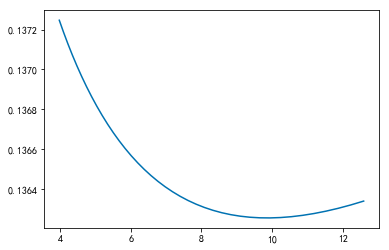

In [22]:
alphas = np.logspace(0.6, 1.1, 40)
scores = []
for alpha in alphas:
    model = Ridge(alpha)
    score = np.sqrt(-cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    scores.append(np.mean(score))
plt.plot(alphas, scores)

In [23]:
ridge = Ridge(alpha=10)

#### BaggingRegressor

In [24]:
from sklearn.ensemble import BaggingRegressor

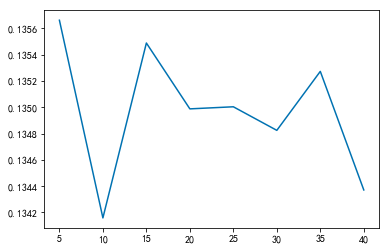

In [25]:
nums = [5, 10, 15, 20, 25, 30, 35, 40]
scores = []
for num in nums:
    bagging = BaggingRegressor(n_estimators=num, base_estimator=ridge)
    score = np.sqrt(-cross_val_score(bagging, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    scores.append(np.mean(score))
plt.plot(nums, scores)

#### XGBoost
Bagging 的效果比单个 ridge 的效果要好，但我还是决定使用 Kaggle 神器 XGBoost

In [22]:
from xgboost import XGBRegressor

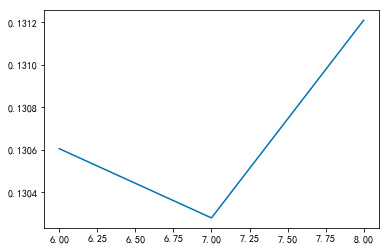

In [25]:
params = [6,7,8]
scores = []
for param in params:
    model = XGBRegressor(max_depth=param)
    score = np.sqrt(-cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    scores.append(np.mean(score))
plt.plot(params, scores)

由此可见 XGBoost 的效果要比前面两个要好，所以决定用这个进行预测

In [27]:
xgbr = XGBRegressor(max_depth=7)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [28]:
y_prediction = np.expm1(xgbr.predict(X_test))

In [29]:
submitted_data = pd.DataFrame(data= {'Id' : test_data.index, 'SalePrice': y_prediction})

In [30]:
submitted_data.head(10)

,Id,SalePrice
0,1461,129750.265625
1,1462,150730.875000
2,1463,191374.921875
3,1464,197844.546875
4,1465,180920.375000
5,1466,177206.109375
6,1467,174674.359375
7,1468,167457.046875
8,1469,192726.234375
9,1470,124529.210938


In [31]:
# 查看数据集的行和列
submitted_data.shape

(1459, 2)

In [32]:
# 将预测结果保存到文件
submitted_data.to_csv('./input/submission.csv', index=False)